In [1]:
import sys
import pickle
import tensorflow as tf
sys.path.append("/visuworks/Blindless_AIFFELTON/Ablation Study/")

# import customized modules
import preprocess, data_generator, check_result, metrics, loss, train

sys.path.append("/visuworks/Blindless_AIFFELTON/Ablation Study/FR_Unet")
import fr_unet

# Insert Path
# {model_name}_{epoch}ep_{model_inpusize}_{Generator | aG/fG/sG}
FILE_NAME = 'fr_unet_50ep_960_fG_wo_slice'
INPUT_SHAPE = (960, 960, 1)
MODEL_PATH = "/visuworks/Blindless_AIFFELTON/Ablation Study/FR_Unet/model_parameters/" + FILE_NAME + ".tf"
HISTORY_PATH = "/visuworks/Blindless_AIFFELTON/Ablation Study/FR_Unet/history/" + FILE_NAME + '_history' ".json"

TRAIN_SOURCE = '/visuworks/Dataset/Selected Dataset 3/Train'
TEST_SOURCE = '/visuworks/Dataset/Selected Dataset 3/Test'

2024-02-13 06:28:43.220469: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-02-13 06:28:43.270518: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-13 06:28:43.270557: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-13 06:28:43.272089: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-02-13 06:28:43.280492: I tensorflow/core/platform/cpu_feature_guar

In [2]:
# Define custom objects for loading the model
custom_objects = {'DiceLoss': loss.DiceLoss(),
                  'sensitivity': metrics.sensitivity,
                  'specificity': metrics.specificity,
                  'accuracy' : metrics.accuracy}


# Create augmentation
# Create augmentation
train_preproc = preprocess.build_augmentation_for_general(INPUT_SHAPE[0], INPUT_SHAPE[0])
test_preproc = preprocess.build_augmentation_for_general(INPUT_SHAPE[0], INPUT_SHAPE[0], is_train=False)

# Create train, test generator
train_generator = data_generator.FullSizedDataGenerator(
    TRAIN_SOURCE,
    batch_size=1,
    img_size=INPUT_SHAPE,
    output_size=INPUT_SHAPE,
    is_train=True,
    is_test=False,
    slice_black=False,
    augmentation= train_preproc
)

test_generator = data_generator.FullSizedDataGenerator(
    TRAIN_SOURCE,
    batch_size=1,
    img_size=INPUT_SHAPE,
    output_size=INPUT_SHAPE,
    is_train=False,
    is_test=True,
    slice_black=False,
    augmentation= test_preproc
)

# Create model
model = fr_unet.FR_UNet(num_classes=1, feature_scale=2, dropout=0.2, fuse=True, out_ave=True)

# # Input shape
input_shape = INPUT_SHAPE

# # Build the model with the specified input shape
model.build(input_shape=(None, *input_shape))

2024-02-08 05:11:16.738372: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1929] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 20763 MB memory:  -> device: 0, name: NVIDIA L4, pci bus id: 0000:00:03.0, compute capability: 8.9


In [ ]:
train.model_train(model,
                  epoch = 50,
                  train_generator = train_generator,
                  test_generator = test_generator,
                  model_path = MODEL_PATH,
                  history_path = HISTORY_PATH,
                  save_every_epoch=True,
                  apply_weight_decay=True,
                  is_load_model=False)

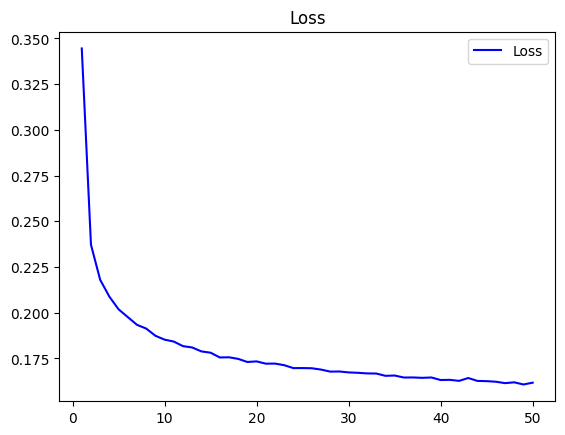

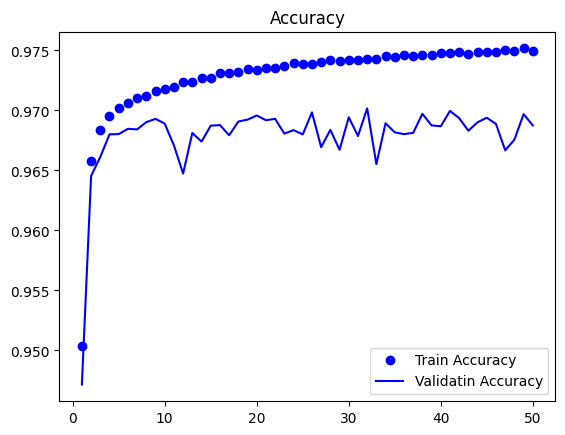

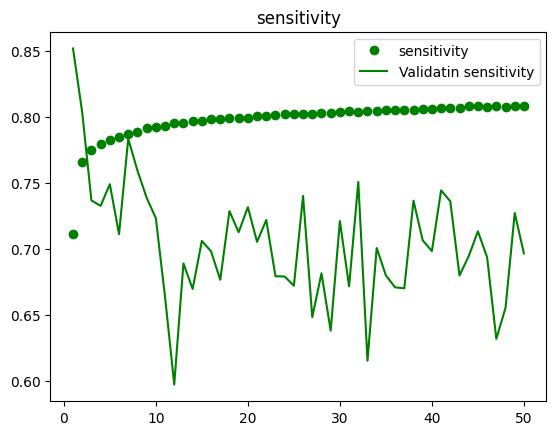

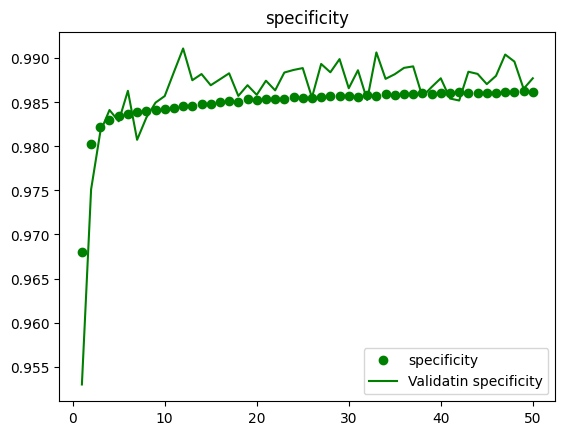

<Figure size 640x480 with 0 Axes>

In [2]:
check_result.plot_history(HISTORY_PATH)

In [ ]:
custom_objects = {'DiceLoss': loss.DiceLoss(), 
                  'sensitivity': metrics.sensitivity,
                  'specificity': metrics.specificity,
                  'accuracy' : metrics.accuracy,
                  'f1_score' : metrics.f1_score,
                  'iou' : metrics.iou}

model_param_path = '/visuworks/Blindless_AIFFELTON/Ablation Study/FR_Unet/model_parameters/fr_unet_50ep_960_fG_wo_slice.tf'
test_preproc = preprocess.build_augmentation_for_general(INPUT_SHAPE[0], INPUT_SHAPE[0], is_train=False)
test_generator = data_generator.FullSizedDataGenerator(
    TEST_SOURCE,
    batch_size=1,
    img_size=INPUT_SHAPE,
    output_size=INPUT_SHAPE,
    is_train=False,
    is_test=True,
    slice_black=False,
    augmentation= test_preproc
)

loss, sen, spe, acc, f1, iou = metrics.retrive_all_evaluation_of_test_dataset(test_generator, model_param_path, custom_objects)

In [ ]:
# Save the metrics as a dictionary
metrics_dict = {
    'loss': loss,
    'sen': sen,
    'spe': spe,
    'acc': acc,
    'f1': f1,
    'iou': iou
}

# Define the file path
file_path = 'metrics_data.pkl'

# Write the metrics to a file using pickle
with open(file_path, 'wb') as f:
    pickle.dump(metrics_dict, f)

In [2]:
file_path = 'metrics_data.pkl'

# Load the metrics from the pickle file
with open(file_path, 'rb') as f:
    metrics_dict = pickle.load(f)

# Access the metrics from the loaded dictionary
loss = metrics_dict['loss']
sen = metrics_dict['sen']
spe = metrics_dict['spe']
acc = metrics_dict['acc']
f1 = metrics_dict['f1']
iou = metrics_dict['iou']

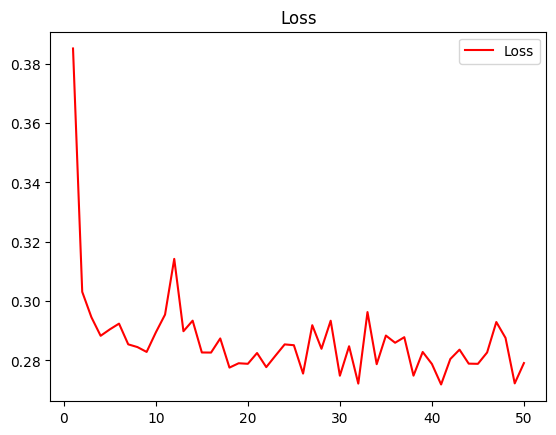

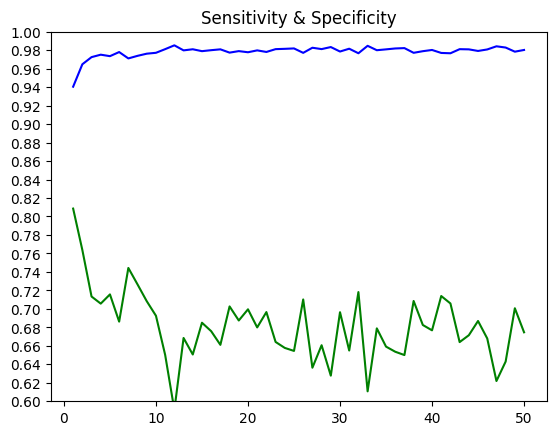

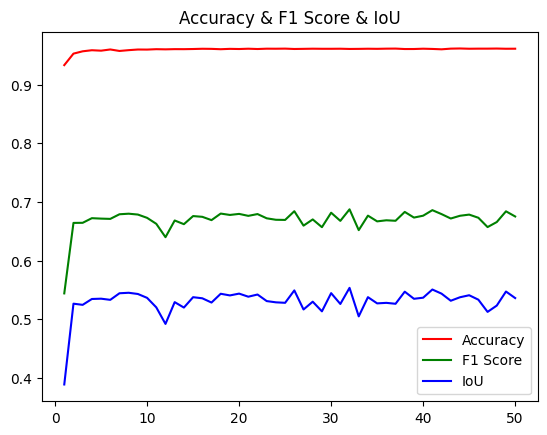

<Figure size 640x480 with 0 Axes>

In [3]:
metrics.plot_test_evaluation_result(loss, sen, spe, acc ,f1, iou)

In [4]:
index = []
for i, l in enumerate (loss):
    if l < 0.28:
        index.append(i+1)
        print(f"{i + 1 }번째 loss value {l}")

18번째 loss value 0.2775926887989044
19번째 loss value 0.27905890345573425
20번째 loss value 0.27887243032455444
22번째 loss value 0.27775493264198303
26번째 loss value 0.2755799889564514
30번째 loss value 0.27486100792884827
32번째 loss value 0.2721976041793823
34번째 loss value 0.27874141931533813
38번째 loss value 0.2748819887638092
40번째 loss value 0.27881884574890137
41번째 loss value 0.2719070017337799
44번째 loss value 0.27892816066741943
45번째 loss value 0.27886447310447693
49번째 loss value 0.2722766399383545
50번째 loss value 0.27912279963493347


In [7]:
index = []
for i, l in enumerate (sen):
    if l > 0.7:
        index.append(i+1)
        print(f"{i + 1 }번째 loss value {l}")

1번째 loss value 0.8085305094718933
2번째 loss value 0.7637393474578857
3번째 loss value 0.7133811712265015
4번째 loss value 0.7056901454925537
5번째 loss value 0.7156651020050049
7번째 loss value 0.7442804574966431
8번째 loss value 0.7264295220375061
9번째 loss value 0.7082796096801758
18번째 loss value 0.7026523947715759
26번째 loss value 0.7101816534996033
32번째 loss value 0.718181312084198
38번째 loss value 0.7085460424423218
41번째 loss value 0.7139042615890503
42번째 loss value 0.7058624625205994
49번째 loss value 0.7006739377975464


In [9]:
for i in index:
    if loss[i-1] < 0.28:
        print(f"{i}번째 결과")
        print(f"loss {loss[i-1]}")
        print(f"specificity {spe[i-1]}")
        print(f"accuracy {acc[i-1]}")
        print(f"f1 score {f1[i-1]}")
        print(f"iou {iou[i-1]}")

18번째 결과
loss 0.2775926887989044
specificity 0.9773276448249817
accuracy 0.9603525996208191
f1 score 0.6801369190216064
iou 0.5434102416038513
26번째 결과
loss 0.2755799889564514
specificity 0.9770916104316711
accuracy 0.9607412815093994
f1 score 0.6841673851013184
iou 0.5491551160812378
32번째 결과
loss 0.2721976041793823
specificity 0.9766485095024109
accuracy 0.9608042240142822
f1 score 0.687381386756897
iou 0.5534950494766235
38번째 결과
loss 0.2748819887638092
specificity 0.9771302938461304
accuracy 0.9606719613075256
f1 score 0.682965874671936
iou 0.5469679236412048
41번째 결과
loss 0.2719070017337799
specificity 0.9769892692565918
accuracy 0.9608197212219238
f1 score 0.6859468817710876
iou 0.5506619811058044
49번째 결과
loss 0.2722766399383545
specificity 0.9783536791801453
accuracy 0.9611405730247498
f1 score 0.6839783787727356
iou 0.5472109913825989
